## Soft Sticky NASCAR data  
Multiple fits for error band.

In [1]:
from bbvi_infer_2l import * 
from nascarsoft import *
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def mean_std_rounded(values):
    values = np.array(values)
    mean = np.mean(values)
    std = np.std(values, ddof=1)  # sample std deviation

    # Round both to 2 decimal places
    mean_rounded = round(mean, 2)
    std_rounded = round(std, 2)

    return f"{mean_rounded} ± {std_rounded}"

### Generate soft sticky observations

In [3]:
K=4 ## state
D=2 ## latent dimension
T=1000 ## timesteps

In [4]:
zs_train, xs_train, ys_train, C = generate_nascar_soft(T=T, K=K, D=D, N=10, temp=0.99, scale=0.02, speed=1, 
                                     fancy=False, gamma=0.25)
zs_test, xs_test, ys_test, C = generate_nascar_soft(T=T, K=K, D=D, N=10, temp=0.99, scale=0.02, 
                            seed=1, speed=1, fancy=False, gamma=0.25, emission=C)

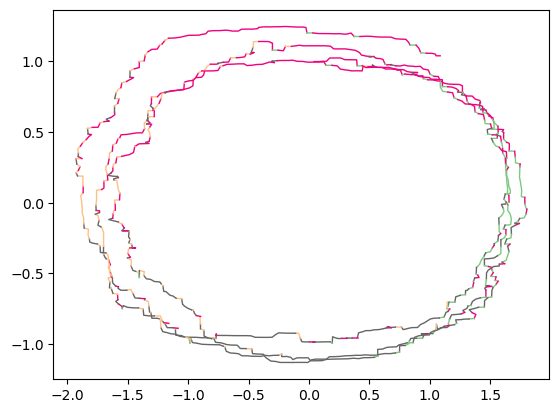

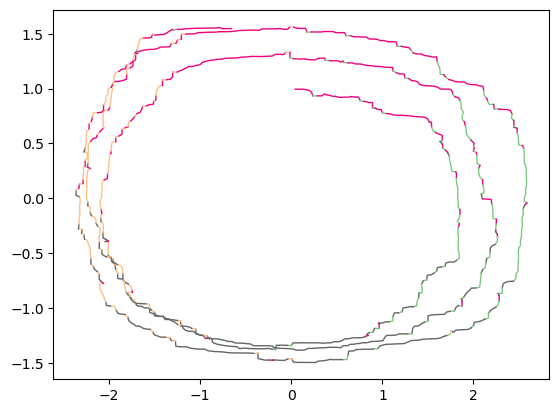

In [5]:
plot_trajectory(np.argmax(zs_train, axis=1), xs_train, ls="-")
plot_trajectory(np.argmax(zs_test, axis=1), xs_test, ls="-")

## GDM 
### GDM Train

In [5]:
trains = []
tests0 = []
tests100 = []
statesq = []
for seed in range(10):  ## repeat tests
    torch.manual_seed(seed)  # Set PyTorch seed
    torch.cuda.manual_seed_all(seed)  # Set CUDA seed 

    model = GenerativeSLDS(N=10, K=4, D=2, emission_model="gaussian")
    elbos, variational_z = fit_bbvi_schedule(model.to('cuda'), ys = torch.tensor(ys_train).to('cuda').float(), 
                                         num_iters=4000, learning=True, n_samples=10, base_lr=1e-2, 
                                         warmup_iters=200, verbose=False)
    ## train
    zs = variational_z.sample_q_z(torch.tensor(ys_train).to('cuda').float().unsqueeze(0).expand(20, -1, -1), 0.99)  ## inferred z2,..z_T
    pred_ys0=model.smooth(torch.tensor(ys_train).to('cuda').float(), zs).mean(dim=0).detach().cpu().numpy() # [T, N]
    train_r2 = train_metrics(ys_train, pred_ys0, None, k_max=0)
    trains.append(train_r2)
    print("Train accuracy:", train_r2)
    
    ## test
    zs2 = variational_z.sample_q_z(torch.tensor(ys_test).to('cuda').float().unsqueeze(0).expand(20, -1, -1), 0.99)  ## inferred z2,..z_T
    pred_ys2=model.smooth(torch.tensor(ys_test).to('cuda').float(), zs2).mean(dim=0).detach().cpu().numpy() # [T, N]
    y_preds, z_preds = predict_k_step_more(k_max=10, model=model, variational_z=variational_z, ys=ys_train)
    test_r2 = train_metrics(ys_test, pred_ys2, y_preds, k_max=10)
    tests0.append(test_r2[0])
    tests100.append(test_r2[-1])
    print("Test accuracy:", test_r2[0], test_r2[-1])
    
    ## state quality
    Z_train = torch.mean(zs, dim=0).detach().cpu().numpy()
    Y_train = np.array(zs_train.argmax(axis=1))
    Z_test = torch.mean(zs2, dim=0).detach().cpu().numpy()
    Y_test = np.array(zs_test.argmax(axis=1))
    # Train KNN classifier
    knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
    knn.fit(Z_train, Y_train)
    acc = knn.score(Z_test, Y_test)
    statesq.append(acc)
    print("Test state quality:", acc)

ELBO: -520.4, LR: 0.01000, Tau: 0.990:   5%|▍         | 197/4000 [00:02<00:40, 93.78it/s] /opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: 21557.4, LR: 0.00100, Tau: 0.990:  65%|██████▌   | 2605/4000 [00:27<00:14, 93.28it/s]


Early stopping at iteration 2605.
Train accuracy: [0.9989744829327055]
Test accuracy: 0.9994178089331756 0.7991964012425103
Test state quality: 0.672


ELBO: -2976.1, LR: 0.01000, Tau: 0.990:   5%|▍         | 190/4000 [00:02<00:41, 90.98it/s]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: 4193.3, LR: 0.00100, Tau: 0.990:  20%|█▉        | 797/4000 [00:08<00:34, 92.97it/s] 


Early stopping at iteration 797.
Train accuracy: [0.9925027591665208]
Test accuracy: 0.9658790935375858 0.38057647875157263
Test state quality: 0.725


ELBO: -4179.8, LR: 0.01000, Tau: 0.990:   5%|▍         | 190/4000 [00:02<00:41, 92.07it/s]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: 3845.8, LR: 0.00100, Tau: 0.990:  22%|██▏       | 885/4000 [00:09<00:34, 89.99it/s] 


Early stopping at iteration 885.
Train accuracy: [0.990558275743734]
Test accuracy: 0.9604978511154563 0.4238552173672809
Test state quality: 0.739


ELBO: -4771.5, LR: 0.01000, Tau: 0.990:   5%|▍         | 196/4000 [00:02<00:43, 88.45it/s]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: 2746.6, LR: 0.00100, Tau: 0.990:  21%|██▏       | 857/4000 [00:09<00:33, 92.58it/s] 


Early stopping at iteration 857.
Train accuracy: [0.9880780415320564]
Test accuracy: 0.9714262524557477 0.4386508630124569
Test state quality: 0.708


ELBO: -4535.9, LR: 0.01000, Tau: 0.990:   5%|▍         | 195/4000 [00:02<00:43, 88.31it/s]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: 1780.7, LR: 0.00100, Tau: 0.990:  16%|█▌        | 623/4000 [00:06<00:36, 92.30it/s] 


Early stopping at iteration 623.
Train accuracy: [0.9830233204141254]
Test accuracy: 0.9330276426132725 0.763400676839819
Test state quality: 0.692


ELBO: 769.0, LR: 0.01000, Tau: 0.990:   5%|▍         | 190/4000 [00:02<00:40, 94.15it/s]  /opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: 24509.4, LR: 0.00100, Tau: 0.990: 100%|██████████| 4000/4000 [00:42<00:00, 93.64it/s]


Train accuracy: [0.9990142224863904]
Test accuracy: 0.9994591989277787 0.7997689275582376
Test state quality: 0.704


ELBO: 739.8, LR: 0.01000, Tau: 0.990:   5%|▍         | 190/4000 [00:02<00:40, 95.22it/s]  /opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: 23665.6, LR: 0.00100, Tau: 0.990:  88%|████████▊ | 3526/4000 [00:37<00:05, 92.99it/s]


Early stopping at iteration 3526.
Train accuracy: [0.9989675118241115]
Test accuracy: 0.9994353355506892 0.7996241970884307
Test state quality: 0.71


ELBO: -2425.0, LR: 0.01000, Tau: 0.990:   5%|▍         | 190/4000 [00:02<00:40, 93.84it/s]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: 19366.8, LR: 0.00100, Tau: 0.990:  96%|█████████▌| 3834/4000 [00:41<00:01, 93.28it/s]


Early stopping at iteration 3834.
Train accuracy: [0.9979325811475375]
Test accuracy: 0.9971922418149581 0.7465138323858955
Test state quality: 0.64


ELBO: -2019.1, LR: 0.01000, Tau: 0.990:   5%|▍         | 190/4000 [00:02<00:40, 94.01it/s]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: 16322.9, LR: 0.00100, Tau: 0.990:  39%|███▉      | 1577/4000 [00:17<00:26, 92.56it/s]


Early stopping at iteration 1577.
Train accuracy: [0.9983502081143392]
Test accuracy: 0.9981474022604662 -1.5791823711644273
Test state quality: 0.684


ELBO: -4195.0, LR: 0.01000, Tau: 0.990:   5%|▍         | 190/4000 [00:02<00:40, 94.18it/s] /opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: 7411.1, LR: 0.00100, Tau: 0.990:  47%|████▋     | 1876/4000 [00:19<00:22, 94.75it/s]


Early stopping at iteration 1876.
Train accuracy: [0.9908752001881652]
Test accuracy: 0.963760799337944 0.7699384193503083
Test state quality: 0.71


In [11]:
mean_std_rounded(statesq),mean_std_rounded(trains),mean_std_rounded(tests0),mean_std_rounded(tests100)

('0.7 ± 0.03', '0.99 ± 0.01', '0.98 ± 0.02', '0.43 ± 0.73')

## Benchmarks
### Sticky Recurrent rSLDS Train

In [6]:
import ssm
from ssm.extensions.mp_srslds.transitions_ext import StickyRecurrentOnlyTransitions, StickyRecurrentTransitions

In [7]:
def slds_k_step_ahead(model, q_lem_z, q_lem_x, ys, k):
    T, N = ys.shape
    D, K = model.D, model.K
    y_preds = np.zeros((T, k, N))
    z_t = q_lem_z.copy()
    C = model.emissions.Cs[0]  # [N, D]
    d = model.emissions.ds[0]  # [N]
    for j in range(k):
        if j == 0:
            x_t = q_lem_x.copy()
        else:
            # Predict next x_t x_{t+1} = A @ x_t + b
            A = np.stack([model.dynamics.As[z] for z in z_t[j:]])  # [T, D, D]
            b = np.stack([model.dynamics.bs[z] for z in z_t[j:]])  # [T, D]
            x_t[j:] = np.einsum('tid,td->ti', A, x_t[j-1:-1]) + b  # [T, D]
        # Predict y_t
        y_preds[:, j, :] = x_t @ C.T + d  # [T, N] 
        input_dummy = np.zeros((T, model.M))  # [T-1, M]
        xmask_dummy = np.ones((T, D), dtype=bool)  # [T-1, D]
        # Compute transition probabilities
        log_Ps = model.transitions.log_transition_matrices(
            x_t, input=input_dummy, mask=xmask_dummy, tag=None)  # [T-1, K, K]
        Ps = np.exp(log_Ps)  
        # Greedy update of z_t
        z_prev = z_t[:-1]
        z_next = np.argmax(Ps[np.arange(T - 1), z_prev], axis=-1)  # [T-1]
        z_t[1:] = z_next
    return y_preds, z_t, x_t  # shape [T, k, N]

ELBO: 22320.6: 100%|██████████| 100/100 [00:10<00:00,  9.39it/s]


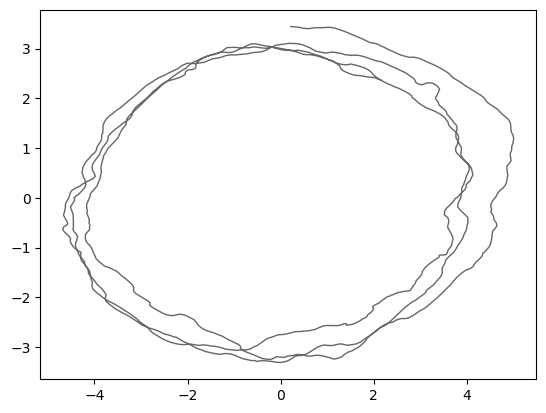

Train accuracy: [0.9992712905621974]
Test accuracy: 0.8010998688118193 0.8006930432558514
Silhouette score at 4 states: -0.11511653477467874
State quality for 4 states: 0.321


ELBO: 22355.9: 100%|██████████| 100/100 [00:10<00:00,  9.60it/s]


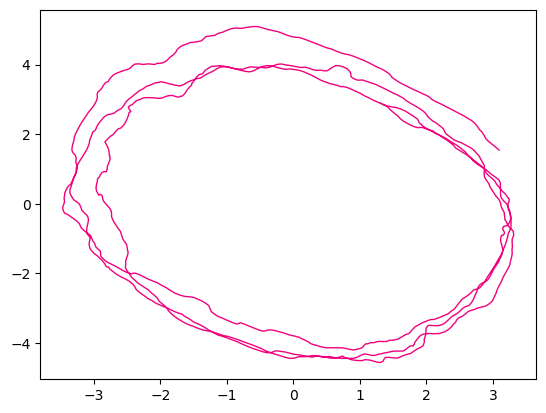

Train accuracy: [0.9992682375326998]
Test accuracy: 0.8008881030737436 0.8003603755675954
Silhouette score at 4 states: -0.11521359848642825
State quality for 4 states: 0.321


ELBO: 22325.2: 100%|██████████| 100/100 [00:10<00:00,  9.43it/s]


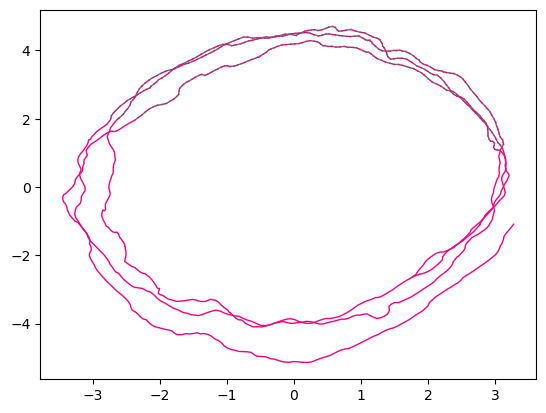

Train accuracy: [0.9992701616310862]
Test accuracy: 0.8010362084003837 0.8006530901825697
Silhouette score at 4 states: -0.199748738429969
State quality for 4 states: 0.368


ELBO: 22279.7: 100%|██████████| 100/100 [00:10<00:00,  9.45it/s]


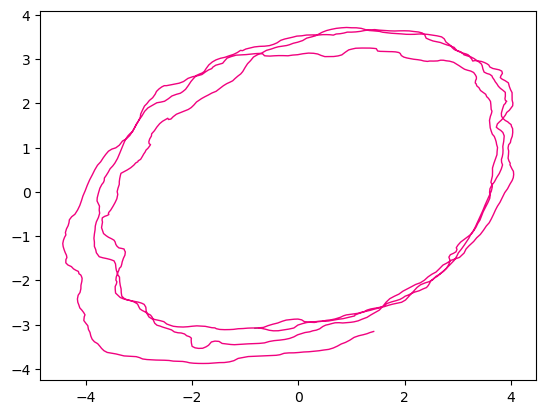

Train accuracy: [0.9992698294899803]
Test accuracy: 0.8010684789282422 0.8007138635912007
Silhouette score at 4 states: -0.11474530014649932
State quality for 4 states: 0.321


ELBO: 22291.5: 100%|██████████| 100/100 [00:10<00:00,  9.56it/s]


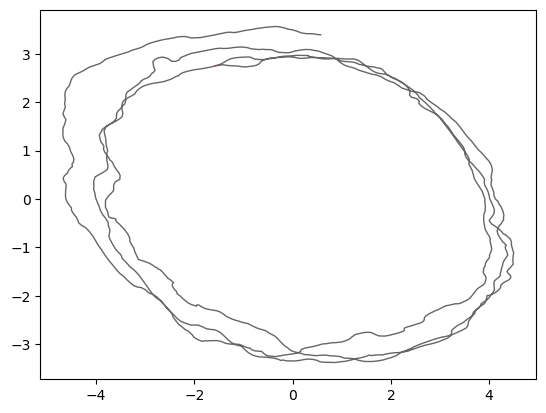

Train accuracy: [0.9992718795914219]
Test accuracy: 0.8010152789165794 0.8008840881952016
Silhouette score at 4 states: -0.11558958402517745
State quality for 4 states: 0.321


ELBO: 22231.5: 100%|██████████| 100/100 [00:10<00:00,  9.47it/s]


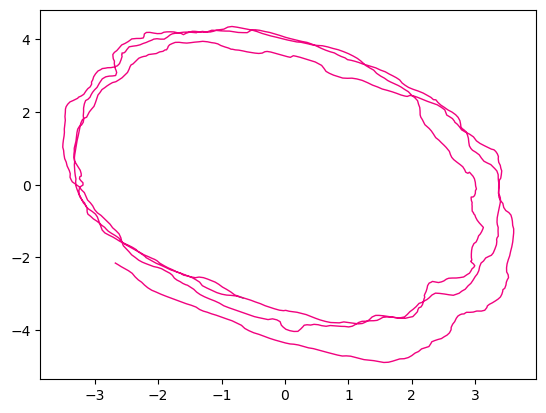

Train accuracy: [0.9992692858664081]
Test accuracy: 0.8012136662220074 0.8008454342525153
Silhouette score at 4 states: -0.11520326259820778
State quality for 4 states: 0.321


ELBO: 22354.3: 100%|██████████| 100/100 [00:10<00:00,  9.57it/s]


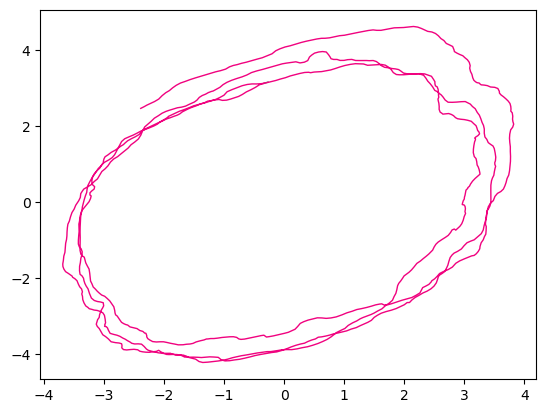

Train accuracy: [0.9992690034127012]
Test accuracy: 0.8011872062240906 0.8007739762981908
Silhouette score at 4 states: -0.11492232309613272
State quality for 4 states: 0.321


ELBO: 22380.8: 100%|██████████| 100/100 [00:10<00:00,  9.44it/s]


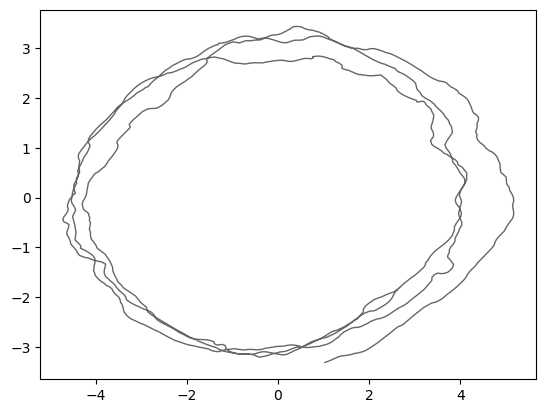

Train accuracy: [0.9992702232053237]
Test accuracy: 0.8011277115030315 0.8006128460636329
Silhouette score at 4 states: -0.11459155473298525
State quality for 4 states: 0.321


ELBO: 22301.3: 100%|██████████| 100/100 [00:10<00:00,  9.49it/s]


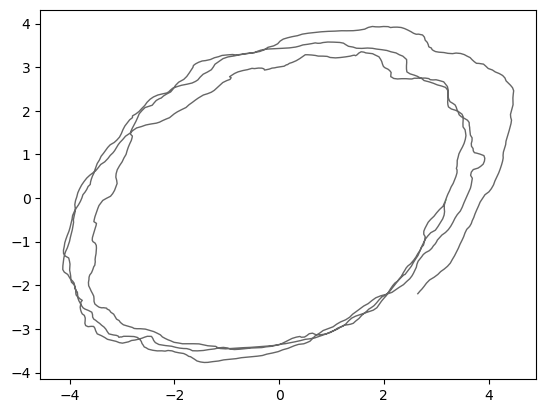

Train accuracy: [0.9992694591128968]
Test accuracy: 0.8009966784676333 0.8007080464563578
Silhouette score at 4 states: -0.11449623054896887
State quality for 4 states: 0.321


ELBO: 22356.6: 100%|██████████| 100/100 [00:10<00:00,  9.40it/s]


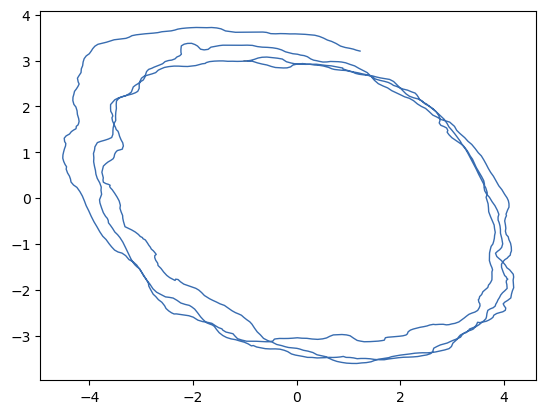

Train accuracy: [0.9992716622617539]
Test accuracy: 0.8010104322678855 0.8007067220129607
Silhouette score at 4 states: -0.11561358358436326
State quality for 4 states: 0.321


In [8]:
trains = []
tests0 = []
tests100 = []
statesq = []
for seed in range(10):  ## repeat tests
    sro_trans=StickyRecurrentOnlyTransitions(K=K,D=D) 
    rslds = ssm.SLDS(N=10, K=4, D=2,
             transitions=sro_trans,
             dynamics="diagonal_gaussian",
             emissions="gaussian",
             single_subspace=True)
    rslds.initialize(ys_train)
    q_elbos_lem, q_lem = rslds.fit(ys_train, method="laplace_em", 
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)
    q_lem_x = q_lem.mean_continuous_states[0]
    q_lem_z = rslds.most_likely_states(q_lem_x, ys_train)
    plot_trajectory(q_lem_z, q_lem_x)
    pred_ys0=rslds.smooth(q_lem_x, ys_train)
    train_r2 = train_metrics(ys_train, pred_ys0, None, k_max=0)
    print("Train accuracy:", train_r2)
    trains.append(train_r2)
    ## no retrain allowed
    pred_ys2=rslds.smooth(q_lem_x, ys_test)
    y_preds, z_preds, x_preds = slds_k_step_ahead(rslds, q_lem_z, q_lem_x, ys_test, k=10)
    test_r2 = train_metrics(ys_test, pred_ys2, y_preds, k_max=10)
    tests0.append(test_r2[0])
    tests100.append(test_r2[-1])
    print("Test accuracy:", test_r2[0], test_r2[-1])
    sil = silhouette_score(q_lem_x, q_lem_z)
    print(f"Silhouette score at {K} states:", sil)
    
    Z_train = np.eye(K)[q_lem_z]
    Y_train = np.array(zs_train.argmax(axis=1))
    Z_test = np.eye(K)[q_lem_z]
    Y_test = np.array(zs_test.argmax(axis=1))
    # Train KNN classifier
    knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
    knn.fit(Z_train, Y_train)
    acc = knn.score(Z_test, Y_test)
    statesq.append(acc)
    print(f"State quality for {K} states:", acc)

In [13]:
mean_std_rounded(statesq),mean_std_rounded(trains),mean_std_rounded(tests0),mean_std_rounded(tests100)

('0.33 ± 0.01', '1.0 ± 0.0', '0.8 ± 0.0', '0.8 ± 0.0')

### Recurrent Only rSLDS Train

ELBO: 22321.4: 100%|██████████| 100/100 [00:11<00:00,  8.98it/s]


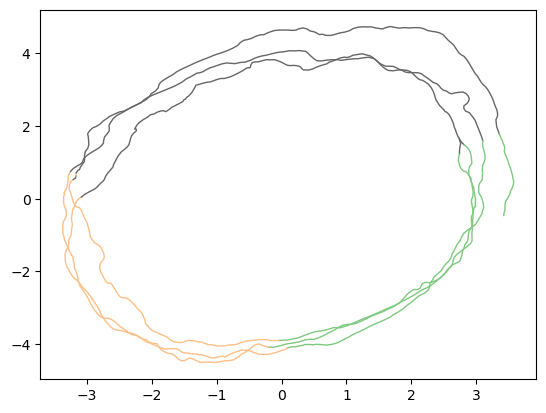

Train accuracy: [0.9992709775228636]
Test accuracy: 0.8011341022362007 0.8003899943641777
Silhouette score at 4 states: 0.4595843558005438
State quality for 4 states: 0.321


ELBO: 22354.6: 100%|██████████| 100/100 [00:11<00:00,  9.09it/s]


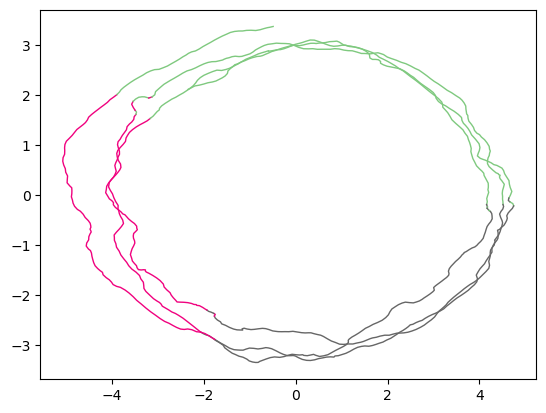

Train accuracy: [0.9992699731910208]
Test accuracy: 0.8008494960764774 0.8004172097441575
Silhouette score at 4 states: 0.3940319187979087
State quality for 4 states: 0.514


ELBO: 22285.1: 100%|██████████| 100/100 [00:11<00:00,  9.07it/s]


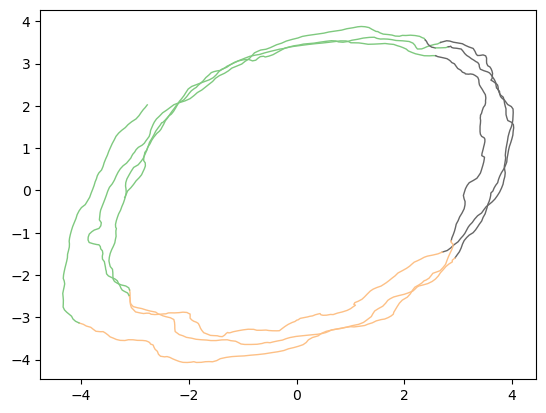

Train accuracy: [0.999269925303375]
Test accuracy: 0.8011685392121102 0.8006145708909782
Silhouette score at 4 states: 0.38753883818383966
State quality for 4 states: 0.589


ELBO: 22324.2: 100%|██████████| 100/100 [00:11<00:00,  8.95it/s]


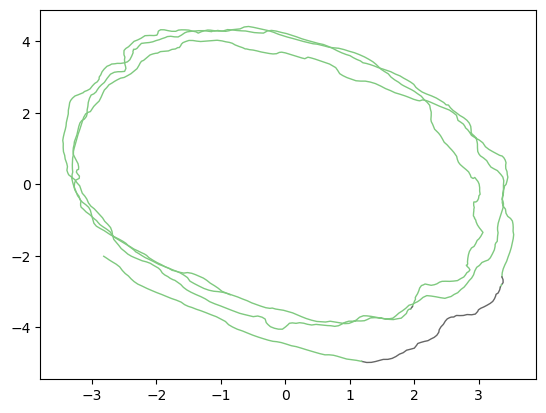

Train accuracy: [0.9992680693186411]
Test accuracy: 0.8011137551620141 0.8004269687920991
Silhouette score at 4 states: 0.10249998767212955
State quality for 4 states: 0.352


ELBO: 22302.8: 100%|██████████| 100/100 [00:11<00:00,  9.06it/s]


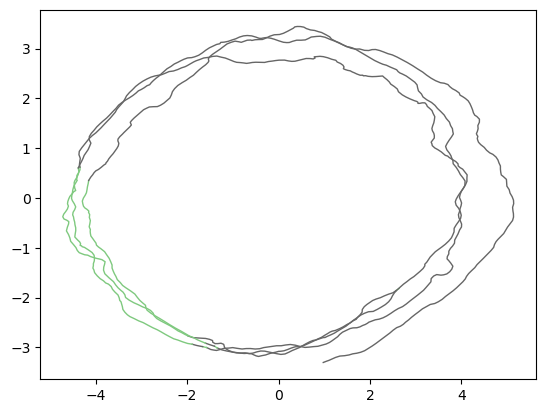

Train accuracy: [0.9992702860491613]
Test accuracy: 0.8010366355804652 0.8008175163108049
Silhouette score at 4 states: 0.2908590328178874
State quality for 4 states: 0.397


ELBO: 22245.9: 100%|██████████| 100/100 [00:11<00:00,  8.95it/s]


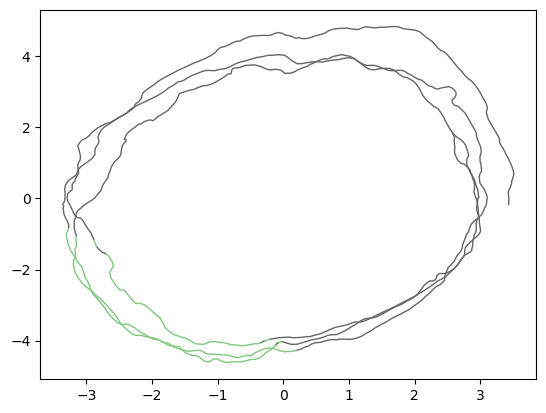

Train accuracy: [0.999271786026083]
Test accuracy: 0.8009306259203791 0.8002429233609416
Silhouette score at 4 states: 0.33076251442455623
State quality for 4 states: 0.321


ELBO: 22350.0: 100%|██████████| 100/100 [00:11<00:00,  9.09it/s]


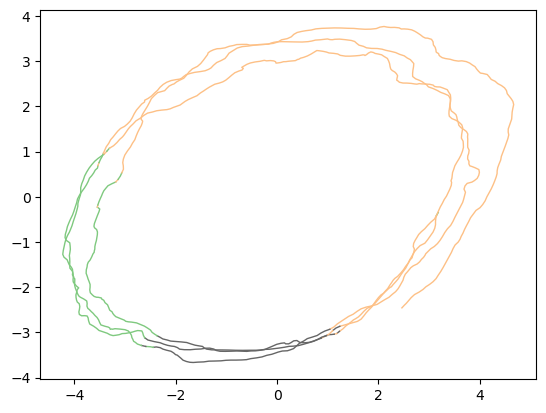

Train accuracy: [0.9992690492383526]
Test accuracy: 0.8009583004877499 0.8005252757096508
Silhouette score at 4 states: 0.3380328712999478
State quality for 4 states: 0.476


ELBO: 22366.9: 100%|██████████| 100/100 [00:11<00:00,  8.92it/s]


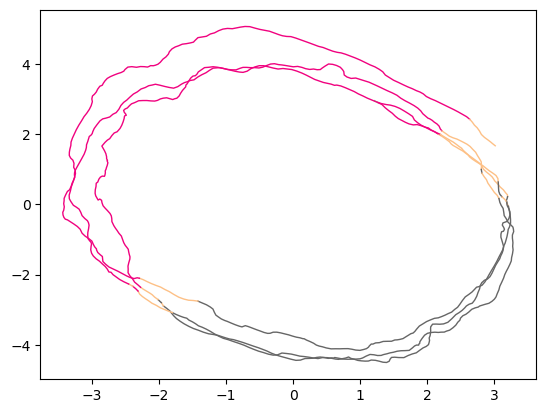

Train accuracy: [0.9992690406250533]
Test accuracy: 0.8010204944299156 0.8007341701938891
Silhouette score at 4 states: 0.09702008700549253
State quality for 4 states: 0.404


ELBO: 22310.6: 100%|██████████| 100/100 [00:11<00:00,  9.07it/s]


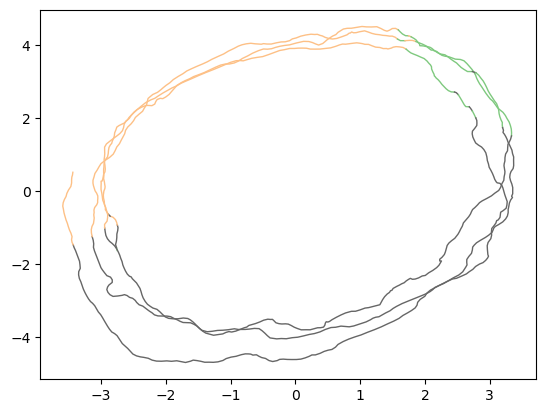

Train accuracy: [0.9992724321961439]
Test accuracy: 0.8011174649970016 0.8006533228359325
Silhouette score at 4 states: 0.28956032097443585
State quality for 4 states: 0.422


ELBO: 22372.7: 100%|██████████| 100/100 [00:11<00:00,  9.05it/s]


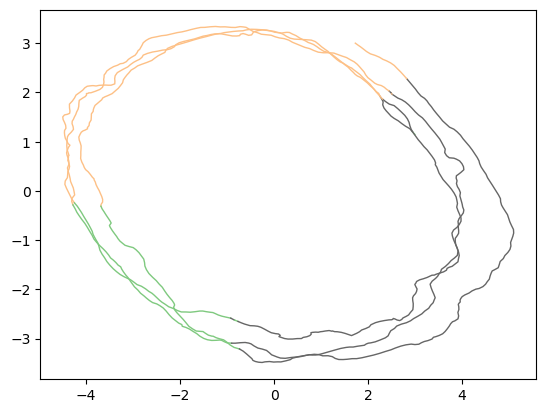

Train accuracy: [0.9992692280264803]
Test accuracy: 0.8010063021841706 0.8006391061305698
Silhouette score at 4 states: 0.38560108988296576
State quality for 4 states: 0.461


In [8]:
trains = []
tests0 = []
tests100 = []
statesq = []
for seed in range(10):  ## repeat tests
    sro_trans=StickyRecurrentOnlyTransitions(K=K,D=D) 
    rslds = ssm.SLDS(N=10, K=4, D=2,
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian",
             single_subspace=True)
    rslds.initialize(ys_train)
    q_elbos_lem, q_lem = rslds.fit(ys_train, method="laplace_em", 
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)
    q_lem_x = q_lem.mean_continuous_states[0]
    q_lem_z = rslds.most_likely_states(q_lem_x, ys_train)
    plot_trajectory(q_lem_z, q_lem_x)
    pred_ys0=rslds.smooth(q_lem_x, ys_train)
    train_r2 = train_metrics(ys_train, pred_ys0, None, k_max=0)
    print("Train accuracy:", train_r2)
    trains.append(train_r2)
    ## no retrain allowed
    pred_ys2=rslds.smooth(q_lem_x, ys_test)
    y_preds, z_preds, x_preds = slds_k_step_ahead(rslds, q_lem_z, q_lem_x, ys_test, k=10)
    test_r2 = train_metrics(ys_test, pred_ys2, y_preds, k_max=10)
    tests0.append(test_r2[0])
    tests100.append(test_r2[-1])
    print("Test accuracy:", test_r2[0], test_r2[-1])
    sil = silhouette_score(q_lem_x, q_lem_z)
    print(f"Silhouette score at {K} states:", sil)
    
    Z_train = np.eye(K)[q_lem_z]
    Y_train = np.array(zs_train.argmax(axis=1))
    Z_test = np.eye(K)[q_lem_z]
    Y_test = np.array(zs_test.argmax(axis=1))
    # Train KNN classifier
    knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
    knn.fit(Z_train, Y_train)
    acc = knn.score(Z_test, Y_test)
    statesq.append(acc)
    print(f"State quality for {K} states:", acc)

In [9]:
mean_std_rounded(statesq),mean_std_rounded(trains),mean_std_rounded(tests0),mean_std_rounded(tests100)

('0.43 ± 0.09', '1.0 ± 0.0', '0.8 ± 0.0', '0.8 ± 0.0')

### SLDS Train

In [18]:
def slds_k_step_ahead(model, q_lem_z, q_lem_x, ys, k):
    T, N = ys.shape
    D, K = model.D, model.K
    y_preds = np.zeros((T, k, N))
    z_t = q_lem_z.copy()
    C = model.emissions.Cs[0]  # [N, D]
    d = model.emissions.ds[0]  # [N]
    for j in range(k):
        if j == 0:
            x_t = q_lem_x.copy()
        else:
            # Predict next x_t x_{t+1} = A @ x_t + b
            A = np.stack([model.dynamics.As[z] for z in z_t[j:]])  # [T, D, D]
            b = np.stack([model.dynamics.bs[z] for z in z_t[j:]])  # [T, D]
            x_t[j:] = np.einsum('tid,td->ti', A, x_t[j-1:-1]) + b  # [T, D]
        # Predict y_t
        y_preds[:, j, :] = x_t @ C.T + d  # [T, N] 
        input_dummy = np.zeros((T, model.M))  # [T-1, M]
        xmask_dummy = np.ones((T, D), dtype=bool)  # [T-1, D]
        # Compute transition probabilities
        log_Ps = model.transitions.log_transition_matrices(
            x_t, input=input_dummy, mask=xmask_dummy, tag=None)  # [T-1, K, K]
        Ps = np.exp(log_Ps)  
        # Greedy update of z_t
        z_prev = z_t[:-1]
        z_next = np.argmax(Ps[0,z_prev], axis=-1)  # [T-1]
        z_t[1:] = z_next
    return y_preds, z_t, x_t  # shape [T, k, N]

ELBO: 22369.9: 100%|██████████| 100/100 [00:07<00:00, 13.69it/s]


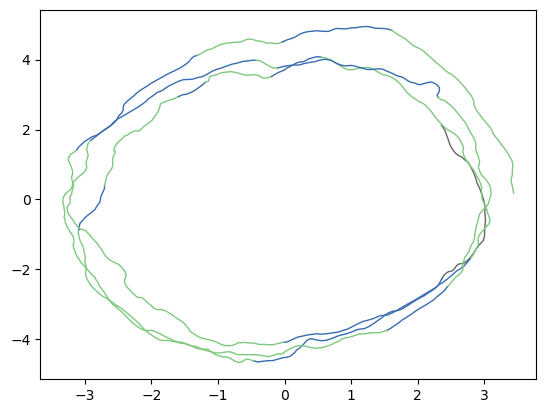

Train accuracy: [0.9992601808242851]
Test accuracy: 0.8011355575004545 0.8004789038166328
Silhouette score at 4 states: -0.05247037821779897
State quality for 4 states: 0.375


ELBO: 22383.4: 100%|██████████| 100/100 [00:07<00:00, 13.98it/s]


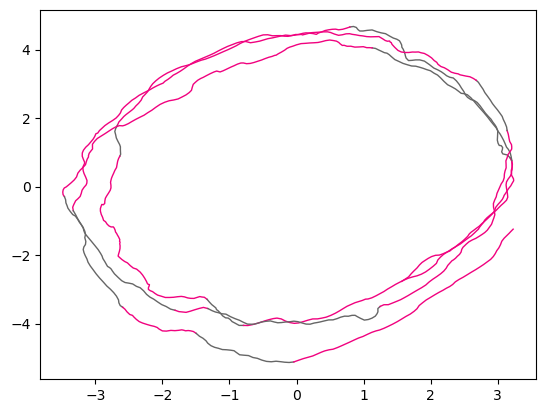

Train accuracy: [0.9992632761875869]
Test accuracy: 0.8009806405634798 0.8002620990599993
Silhouette score at 4 states: 0.04806563089546763
State quality for 4 states: 0.317


ELBO: 22279.6: 100%|██████████| 100/100 [00:07<00:00, 14.00it/s]


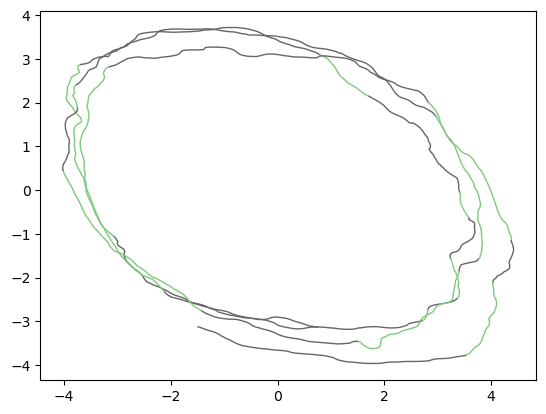

Train accuracy: [0.9992626657975044]
Test accuracy: 0.801103563593729 0.7992828510979141
Silhouette score at 4 states: 0.04543051386419471
State quality for 4 states: 0.302


ELBO: 22348.3: 100%|██████████| 100/100 [00:07<00:00, 13.73it/s]


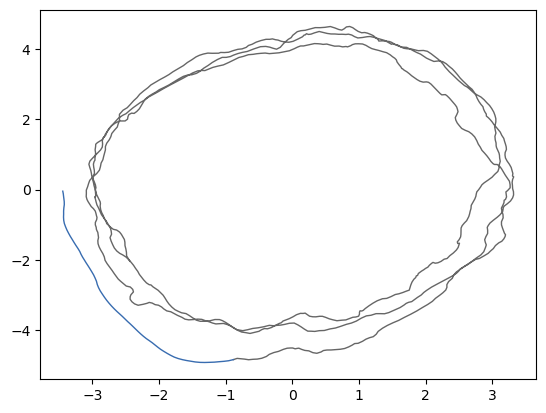

Train accuracy: [0.9992697860437383]
Test accuracy: 0.8009004350519715 0.8002371183157948
Silhouette score at 4 states: 0.08443870493660649
State quality for 4 states: 0.321


ELBO: 22275.6: 100%|██████████| 100/100 [00:07<00:00, 13.95it/s]


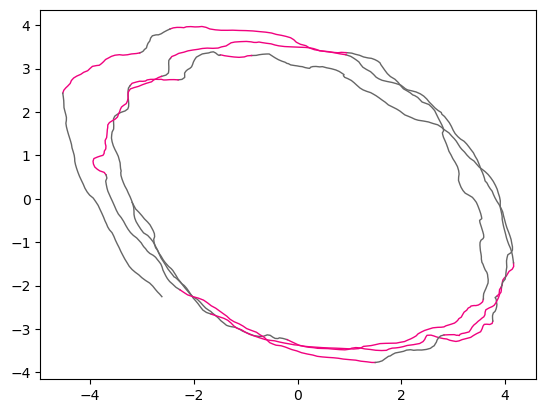

Train accuracy: [0.9992618415454546]
Test accuracy: 0.8008647156795865 0.7992729835680821
Silhouette score at 4 states: 0.06163223788662041
State quality for 4 states: 0.32


ELBO: 22343.4: 100%|██████████| 100/100 [00:07<00:00, 13.95it/s]


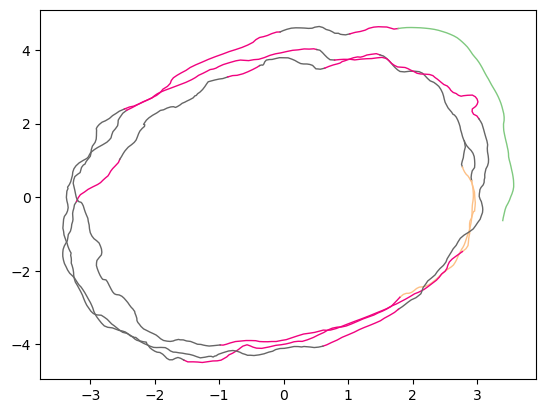

Train accuracy: [0.9992578188540442]
Test accuracy: 0.801150914704766 0.8009084165130815
Silhouette score at 4 states: -0.036870045226547604
State quality for 4 states: 0.31


ELBO: 22342.9: 100%|██████████| 100/100 [00:07<00:00, 13.95it/s]


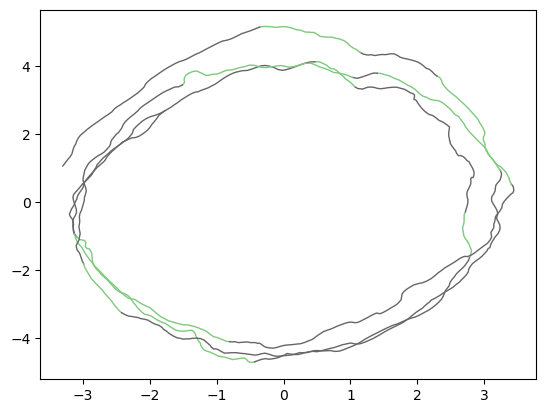

Train accuracy: [0.9992634948603584]
Test accuracy: 0.801090569864288 0.8005044798196094
Silhouette score at 4 states: 0.045609563740357656
State quality for 4 states: 0.316


ELBO: 22290.9: 100%|██████████| 100/100 [00:07<00:00, 13.97it/s]


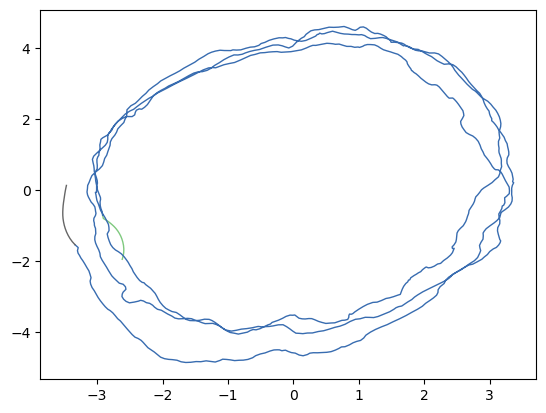

Train accuracy: [0.9992708139536189]
Test accuracy: 0.8011041376655609 0.8004183601704555
Silhouette score at 4 states: -0.08848986238268838
State quality for 4 states: 0.321


ELBO: 22316.3: 100%|██████████| 100/100 [00:07<00:00, 13.93it/s]


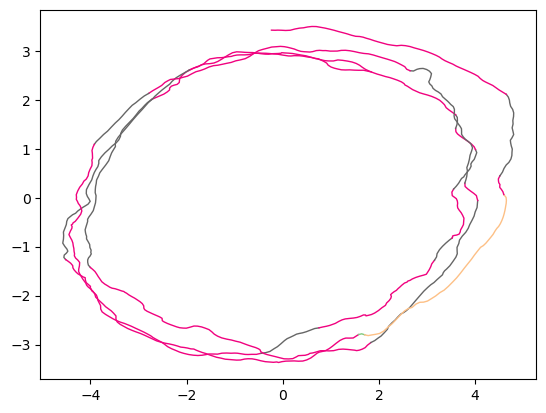

Train accuracy: [0.9992613265187554]
Test accuracy: 0.8010404727021987 0.8001428565956822
Silhouette score at 4 states: -0.19084742203293814
State quality for 4 states: 0.336


ELBO: 22345.9: 100%|██████████| 100/100 [00:07<00:00, 13.71it/s]


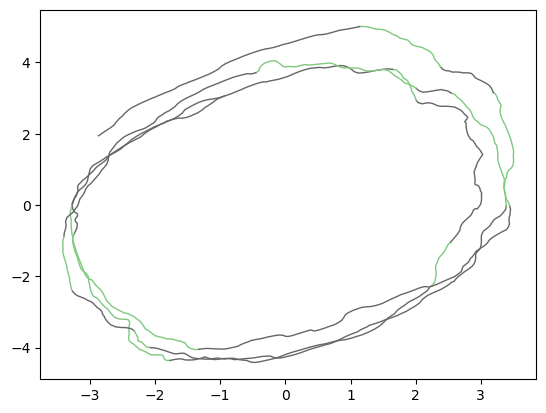

Train accuracy: [0.9992626357836413]
Test accuracy: 0.80110544419708 0.7999369013340754
Silhouette score at 4 states: 0.04872058382788227
State quality for 4 states: 0.322


In [19]:
trains = []
tests0 = []
tests100 = []
statesq = []
for seed in range(10):  ## repeat tests
    rslds = ssm.SLDS(N=10, K=4, D=2,
             transitions="sticky",
             dynamics="diagonal_gaussian",
             emissions="gaussian",
             single_subspace=True)
    rslds.initialize(ys_train)
    q_elbos_lem, q_lem = rslds.fit(ys_train, method="laplace_em", 
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)
    q_lem_x = q_lem.mean_continuous_states[0]
    q_lem_z = rslds.most_likely_states(q_lem_x, ys_train)
    plot_trajectory(q_lem_z, q_lem_x)
    pred_ys0=rslds.smooth(q_lem_x, ys_train)
    train_r2 = train_metrics(ys_train, pred_ys0, None, k_max=0)
    print("Train accuracy:", train_r2)
    trains.append(train_r2)
    ## no retrain allowed
    pred_ys2=rslds.smooth(q_lem_x, ys_test)
    y_preds, z_preds, x_preds = slds_k_step_ahead(rslds, q_lem_z, q_lem_x, ys_test, k=10)
    test_r2 = train_metrics(ys_test, pred_ys2, y_preds, k_max=10)
    tests0.append(test_r2[0])
    tests100.append(test_r2[-1])
    print("Test accuracy:", test_r2[0], test_r2[-1])
    sil = silhouette_score(q_lem_x, q_lem_z)
    print(f"Silhouette score at {K} states:", sil)
    
    Z_train = np.eye(K)[q_lem_z]
    Y_train = np.array(zs_train.argmax(axis=1))
    Z_test = np.eye(K)[q_lem_z]
    Y_test = np.array(zs_test.argmax(axis=1))
    # Train KNN classifier
    knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
    knn.fit(Z_train, Y_train)
    acc = knn.score(Z_test, Y_test)
    statesq.append(acc)
    print(f"State quality for {K} states:", acc)

In [20]:
mean_std_rounded(statesq),mean_std_rounded(trains),mean_std_rounded(tests0),mean_std_rounded(tests100)

('0.32 ± 0.02', '1.0 ± 0.0', '0.8 ± 0.0', '0.8 ± 0.0')

### p-dLDS Train

In [6]:
from pdLDS import pdLDS

In [7]:
trains = []
tests = []
statesq = []
for seed in range(10):  ## repeat tests
    torch.manual_seed(seed)  # Set PyTorch seed
    torch.cuda.manual_seed_all(seed)  # Set CUDA seed 
    
    pdlds = pdLDS(10, 2, 4)
    pdlds.fit(np.expand_dims(ys_train, 0), 200, 
          smooth_c=True, 
          emissions_lr = 1e-3, 
          dynamics_lr = 1e-3, 
          train_iters=25, 
          weight_decay=1, 
          init_iters=5,
          init_smoothness=10, 
          xi=100)
    
    ## train
    pred_ys0=torch.einsum("td,nd->nt", pdlds.emissions, pdlds.latent[0]+pdlds.offsets[0])
    train_r2 = train_metrics(ys_train, pred_ys0, None, k_max=0)
    trains.append(train_r2)
    print("Train accuracy:", train_r2)
    
    ## test
    offsets, latent, coefs, coefs_filt = pdlds.infer([torch.tensor(ys_test).float()])
    pred_ys2=torch.einsum("td,nd->nt", pdlds.emissions, latent[0]+offsets[0])
    test_r2 = train_metrics(ys_test, pred_ys2, None, k_max=0)
    tests.append(test_r2)
    print("Test accuracy:", test_r2)
    
    ## state quality
    Z_train = pdlds.coefs[0].numpy()
    Y_train = np.array(zs_train.argmax(axis=1))[1:]
    Z_test = coefs[0].numpy()
    Y_test = np.array(zs_test.argmax(axis=1))[1:]
    # Train KNN classifier
    knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
    knn.fit(Z_train, Y_train)
    acc = knn.score(Z_test, Y_test)
    statesq.append(acc)
    print("Test state quality:", acc)

Initializing weights with 5 iterations


log pdf: 53409.9492 c:0.0120: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]


Training with  25 iterations


log pdf: 40738.9219 c:0.0130: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Train accuracy: [0.999276339043489]


ELBO: --: 100%|██████████| 1/1 [00:12<00:00, 12.64s/it]


Test accuracy: [0.9995974551923583]
Test state quality: 0.3563563563563564
Initializing weights with 5 iterations


log pdf: 53421.6914 c:0.0430: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Training with  25 iterations


log pdf: 40728.1797 c:0.0110: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Train accuracy: [0.9992730543098596]


ELBO: --: 100%|██████████| 1/1 [00:12<00:00, 12.39s/it]


Test accuracy: [0.9995978260132501]
Test state quality: 0.34234234234234234
Initializing weights with 5 iterations


log pdf: 53409.9492 c:0.0120: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Training with  25 iterations


log pdf: 40735.8633 c:0.0060: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Train accuracy: [0.9992758092589471]


ELBO: --: 100%|██████████| 1/1 [00:12<00:00, 12.59s/it]


Test accuracy: [0.999597559380288]
Test state quality: 0.30430430430430433
Initializing weights with 5 iterations


log pdf: 53409.9492 c:0.0120: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Training with  25 iterations


log pdf: 40738.4297 c:0.0120: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Train accuracy: [0.9992755656112438]


ELBO: --: 100%|██████████| 1/1 [00:12<00:00, 12.68s/it]


Test accuracy: [0.9995975084531112]
Test state quality: 0.35535535535535534
Initializing weights with 5 iterations


log pdf: 53409.9492 c:0.0120: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Training with  25 iterations


log pdf: 40740.7344 c:0.0130: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Train accuracy: [0.9992751088849483]


ELBO: --: 100%|██████████| 1/1 [00:12<00:00, 12.68s/it]


Test accuracy: [0.9995976378696068]
Test state quality: 0.3533533533533533
Initializing weights with 5 iterations


log pdf: 53409.9492 c:0.0120: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Training with  25 iterations


log pdf: 40732.7969 c:0.0230: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Train accuracy: [0.9992750165362632]


ELBO: --: 100%|██████████| 1/1 [00:12<00:00, 12.60s/it]


Test accuracy: [0.9995977509022594]
Test state quality: 0.34534534534534533
Initializing weights with 5 iterations


log pdf: 53409.9492 c:0.0120: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Training with  25 iterations


log pdf: 40738.1758 c:0.0000: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Train accuracy: [0.9992758895122862]


ELBO: --: 100%|██████████| 1/1 [00:12<00:00, 12.69s/it]


Test accuracy: [0.9995974701936886]
Test state quality: 0.32732732732732733
Initializing weights with 5 iterations


log pdf: 53409.9492 c:0.0120: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Training with  25 iterations


log pdf: 40741.9336 c:0.0000: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


Train accuracy: [0.9992755934522884]


ELBO: --: 100%|██████████| 1/1 [00:12<00:00, 12.98s/it]


Test accuracy: [0.9995977784719635]
Test state quality: 0.3133133133133133
Initializing weights with 5 iterations


log pdf: 53409.9492 c:0.0120: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Training with  25 iterations


log pdf: 40724.6953 c:0.0020: 100%|██████████| 25/25 [00:22<00:00,  1.14it/s]


Train accuracy: [0.9992758581536905]


ELBO: --: 100%|██████████| 1/1 [00:12<00:00, 12.65s/it]


Test accuracy: [0.9995978148124426]
Test state quality: 0.3483483483483483
Initializing weights with 5 iterations


log pdf: 53409.9492 c:0.0120: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Training with  25 iterations


log pdf: 40739.9258 c:0.0030: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


Train accuracy: [0.9992754946073694]


ELBO: --: 100%|██████████| 1/1 [00:12<00:00, 12.79s/it]

Test accuracy: [0.999597881700776]
Test state quality: 0.35535535535535534


In [8]:
mean_std_rounded(statesq),mean_std_rounded(trains),mean_std_rounded(tests)

('0.34 ± 0.02', '1.0 ± 0.0', '1.0 ± 0.0')